In [21]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [22]:
csv_name = "/content/parkinsons.csv"
df = pd.read_csv(csv_name)

print("Shape:", df.shape)
df.head()

Shape: (195, 24)


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [23]:
TARGET = "status"
ID_COLS = ["name"]

# Validating
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found. Available columns: {list(df.columns)}")

# Auto-dropping non-feature identifiers
df_clean = df.drop(columns=[c for c in ID_COLS if c in df.columns]).copy()
# Dropping rows with any NaNs
df_clean = df_clean.dropna().copy()

print("After cleaning:", df_clean.shape)
print("Columns:", list(df_clean.columns))
df_clean.head()


After cleaning: (195, 23)
Columns: ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


Top missing:
 MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
dtype: int64


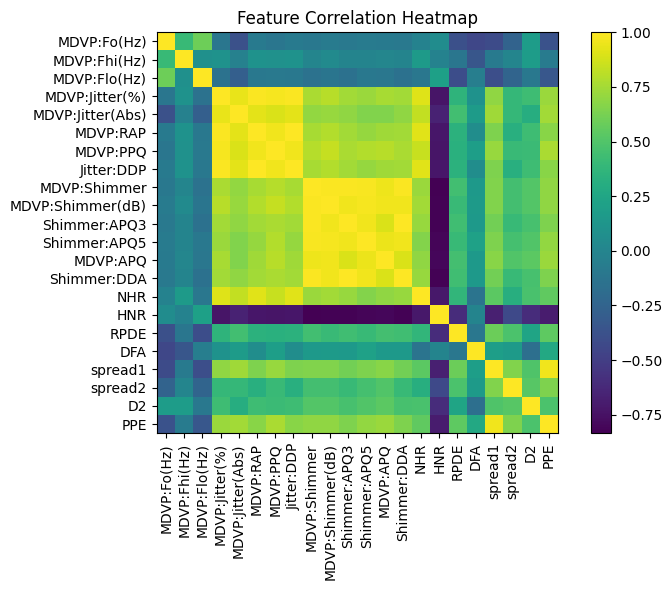

In [24]:

display(df_clean.describe())

# Missing counts
missing = df_clean.isna().sum().sort_values(ascending=False)
print("Top missing:\n", missing.head(10))

# Correlation heatmap for numeric features
features_only = df_clean.drop(columns=[TARGET]).select_dtypes(include=[np.number])
if features_only.shape[1] > 1:
    corr = features_only.corr(numeric_only=True)

    plt.figure(figsize=(8, 6))
    plt.imshow(corr, interpolation="nearest")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Feature Correlation Heatmap")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric features for a correlation heatmap.")


In [25]:
TEST_SIZE = 0.2
SEED = 42

X = df_clean.drop(columns=[TARGET])
y = df_clean[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED
)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()


((156, 22),
 (39, 22),
 status
 1    118
 0     38
 Name: count, dtype: int64,
 status
 1    29
 0    10
 Name: count, dtype: int64)

In [26]:
def get_models_and_grids(random_state: int = 42):
    models = {
        "logreg": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=500, solver="liblinear"))
        ]),
        "rf": Pipeline([
            ("clf", RandomForestClassifier(random_state=random_state, n_jobs=-1))
        ]),
        "svc": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(probability=True, random_state=random_state))
        ]),
    }

    param_grids = {
        "logreg": {
            "clf__C": [0.1, 1.0, 5.0],
            "clf__penalty": ["l1", "l2"]
        },
        "rf": {
            "clf__n_estimators": [200, 400],
            "clf__max_depth": [None, 10, 20]
        },
        "svc": {
            "clf__C": [0.5, 1.0, 2.0],
            "clf__gamma": ["scale", "auto"]
        }
    }
    return models, param_grids

models, grids = get_models_and_grids(SEED)
list(models.keys()), list(grids.keys())


(['logreg', 'rf', 'svc'], ['logreg', 'rf', 'svc'])

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

leaderboard = {}
best = {"name": None, "score": -np.inf, "model": None}

for name, pipe in models.items():
    gs = GridSearchCV(
        pipe,
        grids[name],
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gs.fit(X_train, y_train)
    leaderboard[name] = {"best_score_cv": float(gs.best_score_), "params": gs.best_params_}

    if gs.best_score_ > best["score"]:
        best.update({"name": name, "score": float(gs.best_score_), "model": gs.best_estimator_})

print("CV leaderboard:")
for k, v in leaderboard.items():
    print(f"  {k}: AUC={v['best_score_cv']:.4f} | {v['params']}")
print("\nBest model:", best["name"], "CV AUC:", f"{best['score']:.4f}")


CV leaderboard:
  logreg: AUC=0.9044 | {'clf__C': 1.0, 'clf__penalty': 'l1'}
  rf: AUC=0.9539 | {'clf__max_depth': None, 'clf__n_estimators': 200}
  svc: AUC=0.9072 | {'clf__C': 2.0, 'clf__gamma': 'scale'}

Best model: rf CV AUC: 0.9539


best_rf — Accuracy: 0.9231, ROC AUC: 0.9621, Kappa: 0.7914

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39



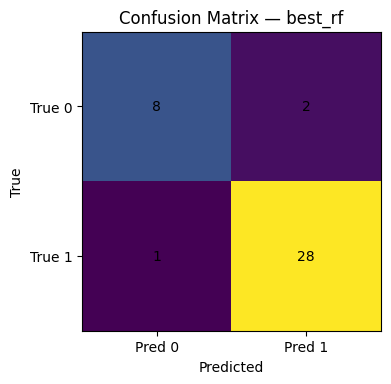

{'accuracy': 0.9230769230769231,
 'roc_auc': 0.9620689655172414,
 'cohen_kappa': 0.7914438502673797,
 'confusion_matrix': [[8, 2], [1, 28]],
 'classification_report_text': '              precision    recall  f1-score   support\n\n           0       0.89      0.80      0.84        10\n           1       0.93      0.97      0.95        29\n\n    accuracy                           0.92        39\n   macro avg       0.91      0.88      0.90        39\nweighted avg       0.92      0.92      0.92        39\n'}

In [28]:
def evaluate(model, X_test, y_test, prefix="best"):
    preds = model.predict(X_test)

    # Accuracy, Kappa
    acc = accuracy_score(y_test, preds)
    kappa = metrics.cohen_kappa_score(y_test, preds)

    # AUC
    proba = None
    if hasattr(model, "predict_proba"):
        try:
            proba = model.predict_proba(X_test)[:, 1]
        except Exception:
            pass

    auc = roc_auc_score(y_test, proba) if proba is not None else float("nan")

    # Classification report
    report_text = classification_report(y_test, preds)
    print(f"{prefix} — Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}, Kappa: {kappa:.4f}")
    print("\nClassification report:\n", report_text)

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix — {prefix}")
    plt.xticks([0, 1], ["Pred 0", "Pred 1"])
    plt.yticks([0, 1], ["True 0", "True 1"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # JSON serializable metrics
    return {
        "accuracy": float(acc),
        "roc_auc": float(auc),
        "cohen_kappa": float(kappa),
        "confusion_matrix": cm.tolist(),
        "classification_report_text": report_text
    }

test_metrics = evaluate(best["model"], X_test, y_test, prefix=f"best_{best['name']}")
test_metrics


In [29]:
OUTPUT_DIR = Path("./artifacts")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Save model
model_path = OUTPUT_DIR / f"best_model_{best['name']}.joblib"
joblib.dump(best["model"], model_path)

# Save leaderboard and model card
with open(OUTPUT_DIR / "cv_leaderboard.json", "w", encoding="utf-8") as f:
    json.dump(leaderboard, f, indent=2)

model_card = {
    "best_model": best["name"],
    "cv_best_score_auc": best["score"],
    "test_metrics": test_metrics,
    "feature_columns": list(X.columns),
    "target_column": TARGET
}
with open(OUTPUT_DIR / "model_card.json", "w", encoding="utf-8") as f:
    json.dump(model_card, f, indent=2)

print("Saved to:", OUTPUT_DIR.resolve())
print("Model file:", model_path)


Saved to: /content/artifacts
Model file: artifacts/best_model_rf.joblib


In [30]:
# demo
loaded = joblib.load(model_path)
demo_preds = loaded.predict(X_test)
print("Demo predictions (first 10):", demo_preds[:10])

Demo predictions (first 10): [1 1 1 1 0 1 1 1 0 1]
